## Table of contents

* [1. Background](#Background)
* [2. Imports](#import)
* [3. Load the data](#Load_Data)
* [4. Is the data imbalanced?](#imblnc)
* [5. Definie predictive features and target feature](#define)
* [6. Appply One Hot Encoder to change the categorical columns](#OneHot)
* [7. Use RandomUnderSampler to balance the data](#rus)
* [8. Split the data to train and test sets](#split)
* [9. Choose the right metrics for model evaluation](#metrics)
* [10. Train models](#model)
    * [9.1. Logistic regression](#lr)
        * [9.1.1.  Make a pipeline for logistic regression model training](#pllr)
        * [9.1.2. Hyperparameter search using GridSearchCV for logistic regression](#gdlr)
        * [9.1.3. Best Logistic Regression model](#bestlr)
    * [9.2. Decision tree classifier](#dt)
        * [9.2.1. Make a pipeline for decision tree](#pldt)
        * [9.2.2. Hyperparameter search for decision tree classifier](#gddt)
        * [9.2.3. Decision tree classifier with best parameters](#bestdt)
        * [9.2.4. Feature importance assessment in the decision tree classifier](#fidt)
    * [9.3. Random forest classifier](#rf)
        * [9.3.1. Make a pipeline for random forest classifier](#plrf)
        * [9.3.2. Hyperparameter search for random forest classifier](#gdrf)
        * [9.3.3. Rondom forest classifier feature importance assessment](#firf)
    * [9.4. Gradient boosting classifier](#GB)
        * [9.4.1. Make a pipeline for gradient boosting classifier](#plgb)
        * [9.4.2. Hyperparameter tuning for gradient boosting classifier](#gdgb)
        * [9.4.3. Gradient boosting feature importance assessment](#figb)
* [10. Summary](#discussion)    

# 1. Background  <a class='anchor' id='Background'></a>

In this notebook we will apply several calssification models to our cleaned data frame of accepted loans from Lending Club. Briefly, Lending Club used to be the biggest peer to peer lending platform. To decide about a loan application, Lending Club relies on applicants' information provided during application. Such information includes income, length employment and credit history. In previous notebooks, we addressed missing data and explore the data to get a better understanding of the data 

In this notebook we will apply several classification models to predict if a loan will default. The models are:

1. Logistic regression

2. Decision tree

3. Random Forest



# 2. Imports <a class='anchor' id='import'></a>

We start by importing required packages.

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_selector as selector
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn import tree, metrics
from IPython.display import Image  
import pydotplus

from xgboost import XGBClassifier, cv, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, f1_score, precision_recall_curve, accuracy_score, confusion_matrix, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression

from sklearn.pipeline import make_pipeline

from sklearn.metrics import fbeta_score, make_scorer

import itertools

import warnings
warnings.filterwarnings('ignore')

from imblearn.under_sampling import NearMiss, RandomUnderSampler

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.compose import ColumnTransformer


# 3. Load the data<a class='anchor' id='Load_Data'></a>

Using the pd.read_csv, we load the data

In [40]:
df = pd.read_csv("C:\\Users\\somfl\\Documents\\Data Science Career Track\\LendingClub\\LendingClubClean.csv")
df = df.drop(columns=['id', 'Unnamed: 0'])

# 4. Is the data imbalanced? <a class='anchor' id='imblnc'><a/>

A data set is called [imbalanced](https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data), if the minority class makes a small percentage of the data set. 

If the minority class (in our case the defaulted loans) makes 20 to 40% of a data set, then it is mildly imbalance.
if the minority class is 1 to 20%, then the dataset is moderately imbalanced and if minority class is < 1% of data set, the data is extremely imbalanced.

To find out if our data set is imbalanced or not, we will look at waht percentages of loan applications in the data frame is defaulted

In [41]:
df.Status.value_counts()/len(df)

Fully Paid    0.784132
Default       0.215868
Name: Status, dtype: float64

Default loans count for 22% of our data set. Therefore, our data is mildly imbalance, which may or may not be a problem. It is suggested to model with the true distribution and if it was not fine, apply techncis such as undersampling to deal with the imbalance.

# 5. Data preparation prior to model training

Due to complexity of our data frame, we definde two functions to handle all the prerocessing steps we need to do prior to training. These steps are:

1. Defining X and y
2. Applying One Hot Encoder to change categorical data
3. Under sampling the data by using RandomUnderSampler
4. spliting the data into training and testing sets.


In [42]:
y = df['Status']
X = df.drop(columns=['Status', 'grade'])

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

Xcol_names = X.columns
ycol_name =['Status']

# Undersample
Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)

# Change back to panads dataframe
X_train = pd.DataFrame(X_train, columns=Xcol_names)
X_test = pd.DataFrame(X_test, columns=Xcol_names)
y_train = pd.DataFrame(y_train, columns=ycol_name)
y_test = pd.DataFrame(y_test, columns=ycol_name)



The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 74


# 6. Choose the right metrics for model evaluation <a class='anchor' id='metrics'></a>

Given that the data is mildly imbalanced, accuracy score is not a good metrics to evaluate performance of a model. It is [recommended](https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html#:~:text=1%20Use%20the%20right%20evaluation%20metrics.%20Applying%20inappropriate,keep%20the%20models%20as%20a%20fixed%20component.%20) to use evaluation metrics such as precision, recal, f1 score or balanced accuracy. We use "balanced accuracy" as our evaluation metrics to compare model performance. 


# 7. Model training <a class='anchor' id='model'></a>

Following classifiers will be trained on the test data:

1. Logistic regression

2. Decision tree

3. Random Forest

4. XGBoost

Steps that we follow for each model include:

1. Make a pipeline, that includes the model and scaling steps and then use cross valiadtion to train a general model. 

2. Grid search to find the hyperparameters.

3. Train the model with the tuned hyperparameters and study feature importance

After training all 4 models, I will use them on the test data and will compare the results to choose the model with the most predictive power.

## 7.1. Logistic regression <a class='anchor' id='lr'></a>

### 7.1.1.  Make a pipeline for logistic regression classifier <a class='anchor' id='pllr'></a>

Using make_pipeline, a pipeline is created to train logistic regression classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

To avoid overfitting, we use cross validation with 5 folds.

In [726]:
# General lr
pipe = make_pipeline( 
    MinMaxScaler(),
    LogisticRegression()
)

lr_cv_results = cross_validate(pipe, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
lr_cv_scores = lr_cv_results['test_score']

print('Balanced accuaracy scores of 5 fold logistic regression are: ', lr_cv_scores)
print('Mean of balanced accuaracy scores of 5 fold logistic regression is: ', lr_cv_scores.mean())

Balanced accuaracy scores of 5 fold logistic regression are:  [0.65378411 0.6537671  0.65264153 0.65261318 0.65388891]
Mean of balanced accuaracy scores of 5 fold logistic regression is:  0.6533389659054338


### 7.1.2. Hyperparameter search using GridSearchCV for logistic regression <a class='anchor' id='gdlr'></a>

Logistic regression has several parameters to tune. These parameters are shown by using get_params().keys(). Given the computing power constraints, a small though important number of features are chosen to tune. These parameters are learning rate and penalty.

In [44]:
pipe = make_pipeline( 
    MinMaxScaler(),
    LogisticRegression()
)
# Define a set of parameters for grid search
grid_params = {'logisticregression__penalty': ['l1','l2'], 'logisticregression__C': [0.1,1,10,100,1000]}

# Perform grid search
lr_grid_cv = GridSearchCV(pipe, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
lr_grid_cv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.1, 1, 10, 100, 1000],
                         'logisticregression__penalty': ['l1', 'l2']},
             scoring='balanced_accuracy')

### 7.1.3. Best Logistic Regression model and feature importance <a class='anchor' id='bestlr'></a>

Now that we know the best hyperparameters for Logistic Regression, we will train the model with the tuned hyperparameteres and look at the cofficients of features to find out the most influential features.

In [45]:
# Get the best parameters
print(lr_grid_cv.best_params_)
lr_gd_best_score = lr_grid_cv.best_score_
print('Mean of balanced accuaracy score of tuned logistic regression is: ', lr_gd_best_score)

{'logisticregression__C': 1000, 'logisticregression__penalty': 'l2'}
Mean of balanced accuaracy score of tuned logistic regression is:  0.65408476103503


Grid serach and tuning hyperparameters did not make a significant change on the initial classification. Next by using the best estimator, we get the coefficients of each feature and will plot feature importance figure.

Text(43.401553819444445, 0.5, 'Feature')

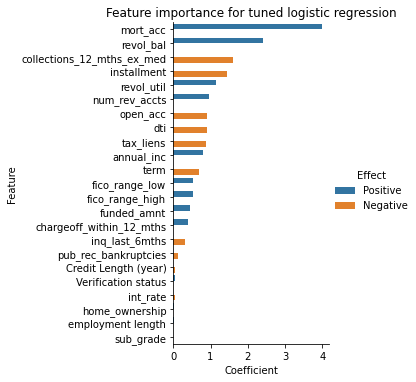

In [738]:
model_features = pd.DataFrame(lr_grid_cv.best_estimator_.named_steps.logisticregression.coef_.T)
model_features.index = X.columns
model_features.columns=['Importance']

HO = model_features.loc['home_ownership_ANY':,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

VS = model_features.loc['verification_status_Not Verified':'verification_status_Verified', :]
vs = pd.DataFrame({'Importance': VS.mean()})
vs.index = ['Verification status']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub, vs])
title = 'Feature importance for tuned logistic regression'
model_features['Effect'] = 'Positive'
model_features.loc[model_features['Importance'] < 0, 'Effect'] = 'Negative'
model_features['Absolute effect'] = abs(model_features['Importance'])
data = model_features.sort_values(by='Absolute effect', ascending=False)

# Plot feature importance
sns.catplot(y= data.index, x='Absolute effect', hue='Effect', kind='bar', data=data)
plt.title(title)
plt.xlabel('Coefficient')
plt.ylabel('Feature')


For the logistic regression, the balanced accuracy score is 65%. 
We can see that, number of _mortage accounts_ followed by amount of _revoling balance_ are the most significant features., followed by number of _collections_ and _installment_ amount. Furthermore, the _sub grade_, _employment length_ and _home ownership_ has very little effect on logistic regression classification result.


In the next step, we will train a decision tree classifier.

## 7.2. Decision tree classifier <a class='anchor' id='dt'></a>
 


### 7.2.1. Make a pipeline for decision tree <a class='anchor' id='pldt'></a>

Using make_pipeline, a pipeline is created to train decision tree classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [743]:
# Make pipeline
y = df['Status']
X = df.drop(columns=['Status', 'grade'])

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

# Save column names
Xcol_names = X.columns
ycol_name = ['Status']
# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)

X_train = pd.DataFrame(X_train, columns=Xcol_names)
y_train = pd.DataFrame(y_train, columns=ycol_name)

pipeTree = make_pipeline( 
    MinMaxScaler(),
    tree.DecisionTreeClassifier()
)

cv_results = cross_validate(pipeTree, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)
print(cv_scores.mean(), cv_scores.std())


The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 74
[0.5681987  0.57353995 0.57074286 0.57097576 0.57114027]
0.5709195088337988 0.001694261725022137


 
Decision tree balanced accuracy score before hyperparameter tuning is 57%, which is worse than logistic regression. Next we will do hyperparameter tuning.

### 9.2.2. Hyperparameter search for decision tree classifier <a class='anchor' id='gddt'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [54]:
pipeTree = make_pipeline( 
    MinMaxScaler(),
    tree.DecisionTreeClassifier()
)
# Define grid parameters

grid_params = {'decisiontreeclassifier__criterion': ['gini', 'entropy'], 'decisiontreeclassifier__max_depth': [3, 6, 9, 12, 15]}

In [55]:
# Perform grid search to find hyperparameters of decision tree

tree_grid_cv = GridSearchCV(pipeTree, param_grid=grid_params, scoring='balanced_accuracy', cv=5, n_jobs=-1)
tree_grid_cv.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'decisiontreeclassifier__criterion': ['gini',
                                                               'entropy'],
                         'decisiontreeclassifier__max_depth': [3, 6, 9, 12,
                                                               15]},
             scoring='balanced_accuracy')

### 9.2.3. Decision tree classifier with best parameters <a class='anchor' id='bestdt'></a>

We access the best parameters by using grid.best_params_

In [56]:
tree_grid_cv.best_params_

{'decisiontreeclassifier__criterion': 'gini',
 'decisiontreeclassifier__max_depth': 9}

We fit a decision tree to the training data by using the best hyperparameters and then, we will look at the importance of the features.

In [759]:
#BestTree = tree.DecisionTreeClassifier(criterion="entropy", max_depth =9, random_state = 1234)
BestTree = tree_grid_cv.best_estimator_
pipeTreeBest = make_pipeline(
    MinMaxScaler(),
    BestTree)

cv_results = cross_validate(pipeTreeBest, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)


[0.64650018 0.64846038 0.64928024 0.65140604 0.64712903]


It can be seen that after hyperparameter tuning, the balanced accuracy of the decision tree model reached 65%. The hyperparameter tuning increased the score from 0.57 to 0.65. In the next step, we will plot the tree as well as the feature importance figure.

In [777]:
from sklearn.tree import export_graphviz

import os     

os.environ["PATH"] += os.pathsep + 'C://Users//somfl//anaconda3//Library//bin//graphviz'

# Now we want to visualize the tree
dot_data = StringIO()

# We can do so with export_graphviz
tree.export_graphviz(pipeTreeBest.named_steps.decisiontreeclassifier, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True, feature_names=X_train.columns,class_names = ['Fully Paid', 'Default'])
# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

AttributeError: decisiontreeclassifier

### 7.2.4. Feature importance assessment in the decision tree classifier <a class='anchor' id='fidt'></a>

Using the "tree_grid_cv.best_estimator_.named_steps.decisiontreeclassifier.feature_importances_", we access the feature importance values and plot them.

Text(0, 0.5, 'Feature')

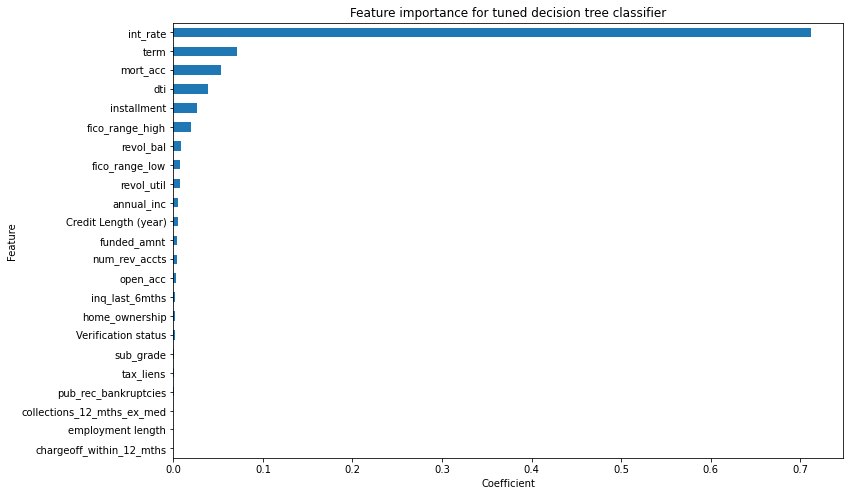

In [788]:
model_features = pd.DataFrame(tree_grid_cv.best_estimator_.named_steps.decisiontreeclassifier.feature_importances_.T)
model_features.index = X.columns
model_features.columns=['Importance']

HO = model_features.loc['home_ownership_ANY':,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

VS = model_features.loc['verification_status_Not Verified':'verification_status_Verified', :]
vs = pd.DataFrame({'Importance': VS.mean()})
vs.index = ['Verification status']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub, vs])
title = 'Feature importance for tuned decision tree classifier'

# Plot feature importance

fig, ax=plt.subplots()
model_features.sort_values(by='Importance').iloc[:, model_features.columns.get_loc('Importance')].plot(kind='barh', figsize=(12,8))
ax.set_title(title)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')




For the decision tree classifier, the balanced accuracy is 65% and according to the feature importance plot, _interest rate_, _loan term_ (either 30 month or 60 month), _number of mortages_, _debt to income ratio_, _installment_, _Low Fico score_, _revolving balance_ and _high Fico score_ are the most influential parameters in decision tree classifier. 


Interest rate has a more significant effect than the other parameters. 


Furthermore, number of _tax liens_, _sub grade_, _bank ruptcies_, _employment length_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

## 7.3. Random forest classifier <a class='anchor' id='rf'></a>

### 7.3.1. Make a pipeline for random forest classifier <a class='anchor' id='plrf'></a>

Using make_pipeline, a pipeline is created to train random forest classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [789]:
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))
cv_results = cross_validate(pipeRF, X_train, y_train, scoring='balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']
print(cv_scores)
print(cv_scores.mean(), cv_scores.std())


[0.65178176 0.65336846 0.65199665 0.65595819 0.65301102]
0.6532232176740888 0.0014918768343255848


### 7.3.2. Hyperparameter search for random forest classifier <a class='anchor' id='gdrf'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [43]:
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))

# Define a grid for hyperparameter tuning with GridSearchCV
param_grid = { 
    'randomforestclassifier__n_estimators': [50, 100, 150],
    'randomforestclassifier__max_depth' : [3, 6, 9],
    'randomforestclassifier__criterion' :['gini', 'entropy']
}

rf_grid_cv_0  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)
rf_grid_cv_0.fit(X_train, y_train)
rf_grid_cv_0.best_params_

{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 150}

As seen above, best parameters for random forest are: 

1. Criterion: gini
2. max_depth: 9
3. n_estimator: 150

The search grid was:

'randomforestclassifier__n_estimators': [50, 100, 150],
'randomforestclassifier__max_depth' : [3, 6, 9],
'randomforestclassifier__criterion' :['gini', 'entropy']

It is not clear if we increase _n_estimator_ or _max_depth_, how the classifier performs. Due to lack of computational power, we will do grid search for random forest parameter in two steps. First we tune n_esimator and we search list of [150, 200, 300, 500, 700, 1000] and then we use the tune _n_estimator_ in the next grid search for max_depth and we search list of [6, 9, 15, 25, 35].



In [790]:
# First step: tuning n_estimator

param_grid = { 
    'randomforestclassifier__n_estimators': [150, 200, 300, 500, 700, 1000],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_depth': [9]
}
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))
rf_grid_cv_1  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)

rf_grid_cv_1.fit(X_train, y_train)
rf_best_cv_1_results = cross_validate(rf_grid_cv_1.best_estimator_, X_train, y_train, cv=5, scoring='balanced_accuracy')
rf_best_scores = rf_best_cv_1_results['test_score']
print(rf_best_scores)
print(rf_best_scores.mean(), rf_best_scores.std())

rf_grid_cv_1.best_params_

[0.65343985 0.65140765 0.65298251 0.65628705 0.65370938]
0.6535652865413835 0.0015773104130714078


{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 700}

Now, we use _n_estimator_ = 700 and tune _max_depth_.

In [8]:
# Second step: tuning max_septh

param_grid = { 
    'randomforestclassifier__n_estimators': [700],
    'randomforestclassifier__criterion': ['gini'],
    'randomforestclassifier__max_depth': [6, 9, 15, 25, 35],
}
pipeRF = make_pipeline(MinMaxScaler(), RandomForestClassifier(random_state=47))
rf_grid_cv2  = GridSearchCV(pipeRF, param_grid = param_grid, scoring='balanced_accuracy', cv = 5, n_jobs = -1)

rf_grid_cv2.fit(X_train, y_train)
rf_best_cv2_results = cross_validate(rf_grid_cv2.best_estimator_, X_train, y_train, cv=5, scoring='balanced_accuracy')
rf_best_scores2 = rf_best_cv2_results['test_score']
print(rf_best_scores2)
print(rf_best_scores2.mean(), rf_best_scores2.std())

rf_grid_cv2.best_params_

[0.65487959 0.65011819 0.65239186 0.65417402 0.65440866]
0.6531944610263174 0.0017539147905660923


{'randomforestclassifier__criterion': 'gini',
 'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 700}



It can be seen that the abalanced accuracy score for the tuned random forest is 65%, very similar to the tune decision tree and logistic regression. In the next step, we plot the feature importance to study effect of features.

### 9.3.3. Feature importance assessment of random forest classifier <a class='anchor' id='firf'></a>



Using rf_grid_cv2.best_estimator_.named_steps.randomforestclassifier.feature_importances_, we access the values and plot them

Text(0, 0.5, 'Feature')

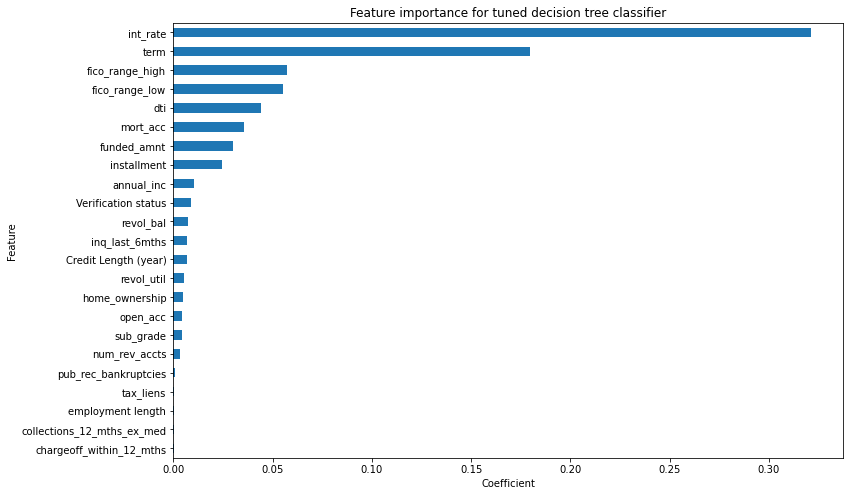

In [9]:
# Plot feature importance for random forest

model_features = pd.DataFrame(rf_grid_cv2.best_estimator_.named_steps.randomforestclassifier.feature_importances_.T)
model_features.index = X.columns
model_features.columns=['Importance']

HO = model_features.loc['home_ownership_ANY':,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']

Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']

Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']

VS = model_features.loc['verification_status_Not Verified':'verification_status_Verified', :]
vs = pd.DataFrame({'Importance': VS.mean()})
vs.index = ['Verification status']

term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub, vs])
title = 'Feature importance for tuned decision tree classifier'

# Plot feature importance

fig, ax=plt.subplots()
model_features.sort_values(by='Importance').iloc[:, model_features.columns.get_loc('Importance')].plot(kind='barh', figsize=(12,8))
ax.set_title(title)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')




For tuned random forest, the balanced accuracy score is 65%, very similar to logistic regression and decision tree.

As shown in the plot,  _interest rate_, _loan term_(either it is 30 month or 60 month), _higher Fico score_ and _low Fico score_, _debt to income ratio_ , _number of mortages_, _funded amount_ and _installment_ are the most influential parameters.

It is worth mentioning that the decision tree reached to almost similar conclusion in the previous section. In a decision tree classifier, the most influential parameters were interest rate, loan term(either it is 30 month or 60 month loan), number of mortages, debt to income ratio, installment, Low Fico score, revolving balance and high Fico score.  

Furthermore, Among the parameters, _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

## 7.4. Gradient boosting classifier <a class='anchor' id='GB'></a>

### 7.4.1. Make a pipeline for gradient boosting classifier <a class='anchor' id='plgb'></a>

Using make_pipeline, a pipeline is created to train gradient boosting classifier. The sacler used is MinMaxScaler. This scaler gives 0 and to the minimum and maximum values of features, and scale the rest of values accordingly. Given that, there are columns with only 0 and 1 to represent categorical features, MinMaXScaler does not change these columns. Therefore, MinMaxScaler is chosen as the scaling method.

In [715]:
y = df['Status']
X = df.drop(columns=['Status', 'grade'])

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)



pipeXG = make_pipeline(MinMaxScaler(), XGBClassifier())

cv_results = cross_validate(pipeXG, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']

print(cv_scores)
print(cv_scores.mean(), cv_scores.std())

The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 74
[12:59:45] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:00:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:01:28] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:02:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:log

Gradient boosting model balanced accuracy score is 66%, which is highest among the models. Decision tree, logistic regression and random forest reached 65% accuracy after tuning.

### 7.4.2. Hyperparameter tuning for gradient boosting classifier <a class='anchor' id='gdgb'></a>

There are several parameters to tune but given the constraints with computing power, only a small number of parameters are chosen.

In [711]:
y = df['Status']
X = df.drop(columns=['Status', 'grade'])

Xcol_names = X.columns
ycol_name =['Status']
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)    

pipeXG = make_pipeline(MinMaxScaler(), XGBClassifier())

parameters = {
    'xgbclassifier__max_depth':[3, 6, 9],
    'xgbclassifier__n_estimator':[100, 200, 500],
    'xgbclassifier__learning_rate': [0.25, 0.2, 0.1],
    }
grid_search_2 = GridSearchCV(pipeXG, param_grid= parameters, cv=5, scoring='balanced_accuracy')
grid_search_2.fit(X_train,y_train)

The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 74
[08:24:34] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:24:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:24:57] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if yo

[08:29:59] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:29:59] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:30:23] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:30:24] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default eva

[08:39:56] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:40:40] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:40:40] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:41:24] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in langua

[08:56:00] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:56:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[08:57:11] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:57:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default eva

[09:03:17] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:03:41] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:03:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:04:07] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in langua

[09:13:43] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:13:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:14:27] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:14:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default eva

[09:28:43] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:29:51] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:29:51] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:31:00] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in langua

[09:38:00] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:38:01] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:38:26] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:38:26] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default eva

[09:47:25] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:48:11] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[09:48:11] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:48:57] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in langua

[10:03:16] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:03:16] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:04:26] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[10:04:27] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default eva

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                                       ('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_depth=None,
                    

In [712]:
print(grid_search_2.best_params_)
print(grid_search_2.best_score_)

{'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimator': 100}
0.6637207267441673


Hyperparameter tuning does not change the result significantly (.663 vs .662). 

In [13]:
pipeXGbest = make_pipeline(MinMaxScaler(), XGBClassifier(learning_rate= 0.2, max_depth= 6, n_estimator= 100))

cv_results = cross_validate(pipeXGbest, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
cv_scores = cv_results['test_score']

print(cv_scores)
print(cv_scores.mean(), cv_scores.std())


[23:01:42] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:01:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:02:29] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:02:30] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default eva

In [710]:
# Print best parameters and results
print(grid_search.best_params_)
print(grid_search.best_score_)

{'xgbclassifier__learning_rate': 0.2, 'xgbclassifier__max_depth': 6, 'xgbclassifier__n_estimator': 100}
0.6589662650390651


### 9.4.3. Gradient boosting feature importance assessment <a class='anchor' id='figb'></a>

In [29]:
model_features = pd.DataFrame(pipeXGbest.named_steps['xgbclassifier'].feature_importances_.T)
model_features.columns=['Importance']

model_features.index = X.columns
model_features.columns=['Importance']
HO = model_features.loc['home_ownership_ANY':,:]
HO = pd.DataFrame({'Importance': HO.mean()})
HO.index = ['home_ownership']
Emp = model_features.loc['emp_length_1 year':'emp_length_< 1 year', :]
Emp = pd.DataFrame({'Importance': Emp.mean()})
Emp.index = ['employment length']
Sub = model_features.loc['sub_grade_A1':'sub_grade_G5', :]
sub = pd.DataFrame({'Importance': Sub.mean()})
sub.index = ['sub_grade']
term = pd.DataFrame({'Importance': model_features.loc['term_ 60 months',:]})
term.index = ['term']

model_features = pd.concat([model_features.loc[:'Credit Length (year)',:], term, HO, Emp, sub])
title = 'Feature importance for tuned XGBbooster regression'

# Plot feature importance
fig, ax=plt.subplots()
model_features.sort_values(by='Importance').iloc[:, model_features.columns.get_loc('Importance')].plot(kind='barh', figsize=(12,8))
ax.set_title(title)
ax.set_xlabel('Coefficient')
ax.set_ylabel('Feature')


AttributeError: Feature importance is not defined for Booster type None

In [32]:
mm = pipeXGbest.named_steps['xgbclassifier']

In [33]:
from xgboost import plot_importance
plot_importance(mm, max_num_features=10)

NotFittedError: need to call fit or load_model beforehand

In [37]:
pipeXGbest.named_steps.xgbclassifier

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=0.2, max_delta_step=None, max_depth=6,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimator=100, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, validate_parameters=None, verbosity=None)

In [17]:
pipeXGbest.steps

[('minmaxscaler', MinMaxScaler()),
 ('xgbclassifier',
  XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
                colsample_bynode=None, colsample_bytree=None, gamma=None,
                gpu_id=None, importance_type='gain', interaction_constraints=None,
                learning_rate=0.2, max_delta_step=None, max_depth=6,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                n_estimator=100, n_estimators=100, n_jobs=None,
                num_parallel_tree=None, random_state=None, reg_alpha=None,
                reg_lambda=None, scale_pos_weight=None, subsample=None,
                tree_method=None, validate_parameters=None, verbosity=None))]

According to the balanced accuracy score, gradient boosting is slightly better than previous models. The balanced accuracy score is 66%.

According to the feature importance plot, _interest rate_, _term_, the number of _mortage accounts_ , _high Fico score_, _funded amount_, _debt to income ratio_, _installment_, and _revolving balance_ are the most influential parameters in the classification. _interset rate_ and _term_ have more significant effect compared to other parameters.

Among the parameters, _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.

# 8. Final model selection <a class='anchor' id='select'><a/>

In [49]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    classes = ['Default', 'Fully Paid']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## 8.1. Logistic regression <a class='anchor' id='lr_test'><a/>

In [46]:
lr_y_pred = lr_grid_cv.best_estimator_.predict(X_test)

In [52]:
print('Balanced accuracy score for the test data is: ', balanced_accuracy_score(y_test, lr_y_pred))

Balanced accuracy score for the test data is:  0.6534873873018496


In [48]:
lr_y_pred =pd.Series(lr_y_pred)
print(classification_report(lr_y_pred,y_test))

              precision    recall  f1-score   support

     Default       0.68      0.65      0.66     82181
  Fully Paid       0.63      0.66      0.64     74120

    accuracy                           0.65    156301
   macro avg       0.65      0.65      0.65    156301
weighted avg       0.65      0.65      0.65    156301



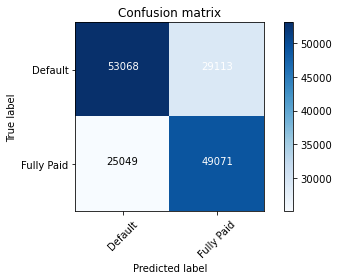

In [51]:
# Plot confusion matrix

confusion_matrix_lr = confusion_matrix(lr_y_pred, y_test)
plot_confusion_matrix(confusion_matrix_lr)

## 8.2. Decision tree <a class='anchor' id='dt_test' ><a/>

In [57]:
dt_y_pred = tree_grid_cv.best_estimator_.predict(X_test)
print('Decision tree balanced accuracy score for the test data is: ', balanced_accuracy_score(y_test, dt_y_pred))

Decision tree balanced accuracy score for the test data is:  0.648326621532569


In [58]:
dt_y_pred =pd.Series(dt_y_pred)
print(classification_report(dt_y_pred, y_test))

              precision    recall  f1-score   support

     Default       0.66      0.64      0.65     80705
  Fully Paid       0.63      0.65      0.64     75596

    accuracy                           0.65    156301
   macro avg       0.65      0.65      0.65    156301
weighted avg       0.65      0.65      0.65    156301



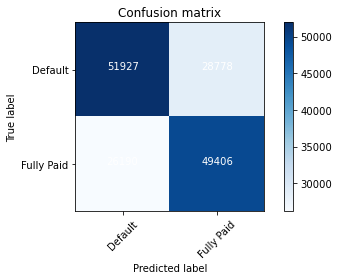

In [64]:
# Plot confusion matrix

confusion_matrix_dt = confusion_matrix(dt_y_pred, y_test)
plot_confusion_matrix(confusion_matrix_dt)

## 8.4. Random forest <a class='anchor' id='rf_test'><a/>

In [61]:
rf_y_pred = rf_grid_cv2.best_estimator_.predict(X_test)
print('Random forest balanced accuracy score for the test data is: ', balanced_accuracy_score(y_test, rf_y_pred))

Random forest balanced accuracy score for the test data is:  0.6536639183838509


In [62]:
rf_y_pred =pd.Series(rf_y_pred)
print(classification_report(rf_y_pred, y_test))

              precision    recall  f1-score   support

     Default       0.69      0.64      0.67     83562
  Fully Paid       0.62      0.67      0.64     72739

    accuracy                           0.65    156301
   macro avg       0.65      0.65      0.65    156301
weighted avg       0.66      0.65      0.65    156301



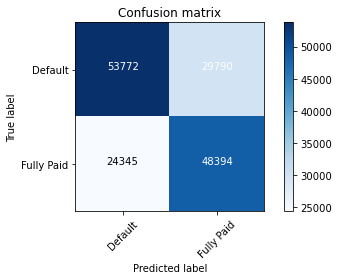

In [63]:
# Plot confusion matrix

confusion_matrix_rf = confusion_matrix(rf_y_pred, y_test)
plot_confusion_matrix(confusion_matrix_rf)

## 8.4. XGBoost <a class='anchor' id='XG_test'><a/>

In [70]:
pipeXGbest = make_pipeline(MinMaxScaler(), XGBClassifier(learning_rate= 0.2, max_depth= 6, n_estimator= 100))
pipeXGbest.fit(X_train, y_train)

[11:21:29] WARNING: ..\src\learner.cc:541: 
Parameters: { n_estimator } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[11:21:29] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.2,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimator=100,
                               n_estimators=100, n_jobs=8, num_parallel_tree=1,
                               random_state=0, reg_alpha=0, reg_lambda=1,
                               scale_pos_weight=1, subsample=1,
                               tree_method='exact', validate_parameters=1,
                               verbosity=None))])

In [71]:
xg_y_pred = pipeXGbest.predict(X_test)

print('XGBoost balanced accuracy score for the test data is: ', balanced_accuracy_score(y_test, xg_y_pred))

XGBoost balanced accuracy score for the test data is:  0.6630322341303667


In [72]:
xg_y_pred =pd.Series(xg_y_pred)
print(classification_report(xg_y_pred, y_test))

              precision    recall  f1-score   support

     Default       0.69      0.66      0.67     81875
  Fully Paid       0.64      0.67      0.65     74426

    accuracy                           0.66    156301
   macro avg       0.66      0.66      0.66    156301
weighted avg       0.66      0.66      0.66    156301



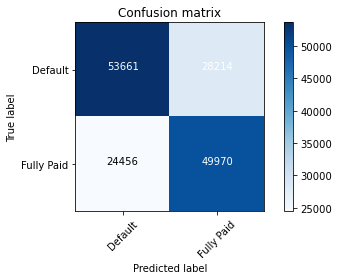

In [73]:
# Plot confusion matrix for XGBoost

confusion_matrix_xg = confusion_matrix(xg_y_pred, y_test)
plot_confusion_matrix(confusion_matrix_xg)

## 8.5. Discussion <a class='anchor' id='disc'><a/>
    
    
XGBoost performs slightly better. 

## Drop _sub_grade_ column and keep _grade_ and train logistic regression

In [394]:
y = df['Status']
X = df.drop(columns=['Status', 'sub_grade'])

# Choose the categorical columns
col_num =X.shape[1]
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(X)

# One Hot encode

enc = OneHotEncoder(drop='if_binary')
enc_df = pd.DataFrame(enc.fit_transform(X[categorical_columns]).toarray())
feature_names = enc.get_feature_names(input_features=categorical_columns)
enc_df.columns = feature_names
X.drop(columns=categorical_columns, inplace=True)
# merge with main df bridge_df on key values
X =X.join(enc_df)
#X.set_index('id', inplace=True)
print('The new X has the columns added by One Hot Encoder, which has increased the number of columns from {} to {}'.format(col_num, X.shape[1]))

# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)

The new X has the columns added by One Hot Encoder, which has increased the number of columns from 23 to 46


In [395]:
gen2_lr_cv_results = cross_validate(pipe, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
gen2_lr_cv_scores = gen2_lr_cv_results['test_score']
print('Balanced accuaracy scores of 5 fold logistic regression are: ', gen2_lr_cv_scores)
print('Mean of balanced accuaracy scores of 5 fold logistic regression is: ', gen2_lr_cv_scores.mean())

Balanced accuaracy scores of 5 fold logistic regression are:  [0.65348393 0.65125867 0.65139439 0.65641268 0.6543841 ]
Mean of balanced accuaracy scores of 5 fold logistic regression is:  0.6533867523630119


When replacing _sub grade_ with _grade_ the balanced accuracy score changed from 0.654 to 0.653, which is not significant. Given the complexity of the model training, and the amount of time it takes to train models, for the SelectKBest analysis I substitute _sub grade_ with _grade_. There are 35 subgrades, while there are only 7 grades. This substitution reduces the size of the X natrix significantly.

## Feature Selection using SelectKBest

 We will use select best to see if the number of parameters affect model training
Bases on the plot k = 16 gives the highest score. SelectKBest was only applied to the numerical columns and all the categorical columns were incuded. I use GridSEarch CV with  k=8 numerical parameters and find the hyperparameters.

In [481]:
result ={}
MeanScore = []
scores_5cv = []
StdScore = []
for i in range(18):
    k_f = 18 - i
    y = df['Status']
    X = df.drop(columns=['Status', 'sub_grade'])
    
    Xcol_names = X.columns
    ycol_name =['Status']
    
    # Undersample

    Xn = X.to_numpy()
    yn = y.to_numpy()
    random_state=42
    RU = RandomUnderSampler()
    X_res, y_res = RU.fit_resample(Xn,yn)

    # Split    
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)
    X_train = pd.DataFrame(X_train, columns=Xcol_names)
    y_train = pd.DataFrame(y_train, columns=ycol_name)

    numerical_columns = X.select_dtypes(exclude=['object']).columns
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler()), ('sss', SelectKBest(chi2, k=k_f))])


    categorical_columns = X.select_dtypes(include=['object']).columns
    categorical_transformer = OneHotEncoder(drop='if_binary')


    preprocessor = ColumnTransformer(transformers=[
        ("num", numeric_transformer, numerical_columns),
        ("cat", categorical_transformer, categorical_columns),
    ])

    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())])
    cv_result = cross_validate(pipe, X_train, y_train, scoring = 'balanced_accuracy', cv=5)
    Result_scores = cv_result['test_score']
    MeanScore.append(Result_scores.mean())
    StdScore.append(Result_score.std())
    #features_list[kb.get_support()]
    scores_5cv.append(Result_scores)
    result.update({k_f: Result_scores})
    
Result = pd.DataFrame.from_dict(result, orient='index')        

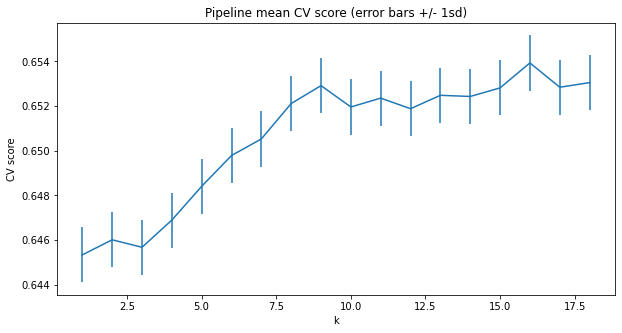

In [483]:
# Plot the CV score versus k

plt.subplots(figsize=(10, 5))
plt.errorbar(Result.index, MeanScore, StdScore)
plt.xlabel('k')
plt.ylabel('CV score')
plt.title('Pipeline mean CV score (error bars +/- 1sd)');

In [583]:
y = df['Status']
X = df.drop(columns=['Status', 'sub_grade'])
    
Xcol_names = X.columns
ycol_name =['Status']
    
# Undersample

Xn = X.to_numpy()
yn = y.to_numpy()
random_state=42
RU = RandomUnderSampler()
X_res, y_res = RU.fit_resample(Xn,yn)

    # Split    
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=47)
X_train = pd.DataFrame(X_train, columns=Xcol_names)
y_train = pd.DataFrame(y_train, columns=ycol_name)

numerical_columns = X.select_dtypes(exclude=['object']).columns
numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler()), ('sss', SelectKBest(chi2, k=8))])


categorical_columns = X.select_dtypes(include=['object']).columns
categorical_transformer = OneHotEncoder(drop='if_binary')


preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numerical_columns),
    ("cat", categorical_transformer, categorical_columns),
])
pipe = Pipeline(steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression())])

# Do a grid search

grid_params = {'classifier__penalty': ['l1','l2'], 'classifier__C': [0.1,1,10,100,1000]}

# Perform grid search
lr_grid_cv_Kbest = GridSearchCV(pipe, param_grid=grid_params, cv=5, scoring = 'balanced_accuracy', n_jobs=-1)
lr_grid_cv_Kbest.fit(X_train, y_train)

print(lr_grid_cv_Kbest.best_params_)
lr_grid_cv_Kbest_score = lr_grid_cv_Kbest.best_score_
print('Mean of balanced accuaracy score of tuned logistic regression with best 8 numerical features is: ', lr_grid_cv_Kbest_score)        

{'classifier__C': 100, 'classifier__penalty': 'l2'}
Mean of balanced accuaracy score of tuned logistic regression with best 8 numerical features is:  0.6526599753244616


The mean balanced accuracy score with 8 numerical features and all categorical features is very comparable to the tuned model with all parameters. By using get_support(), we check what parameters are used with SelectKBest.

In [667]:
## Check SelectKBest parameters
selected = lr_grid_cv_Kbest.best_estimator_.named_steps.preprocessor.named_transformers_.num.named_steps.sss.get_support()

In [680]:
Feature_mask = list(selected)
for i in range(5):
    Feature_mask.append(True)

features = list(numerical_columns) + list(categorical_columns)
Col_names = pd.DataFrame(zip(features,Feature_mask), columns=['Feature', 'value'])
Features = Col_names.loc[Col_names['value']==True, 'Feature']
list(Features)

['dti',
 'inq_last_6mths',
 'mort_acc',
 'funded_amnt',
 'installment',
 'int_rate',
 'fico_range_high',
 'fico_range_low',
 'grade',
 'verification_status',
 'term',
 'emp_length',
 'home_ownership']

Text(31.466875000000016, 0.5, 'Feature')

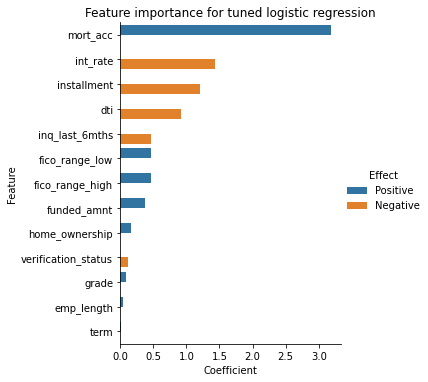

In [696]:
model_features = pd.DataFrame(lr_grid_cv_Kbest.best_estimator_.named_steps.classifier.coef_.T)
model_features.columns=['Importance']

grades = model_features.iloc[8:15, :]
grade = pd.DataFrame({'Importance': grades.mean()})

VSs = model_features.iloc[16:19, :]
VS = pd.DataFrame({'Importance': VSs.mean()})

term = pd.DataFrame({'Importance': model_features.iloc[19, :]})

Emps = model_features.loc[20:31, :]
Emp = pd.DataFrame({'Importance': Emps.mean()})

HOs = model_features.iloc[31:,:]
HO = pd.DataFrame({'Importance': HOs.mean()})



model_features = pd.concat([model_features.iloc[:8,:], grade, VS, term, Emp, HO])
model_features.index=Features

model_features['Absolute effect'] = abs(model_features['Importance'])

model_features['Effect'] = 'Positive'
model_features.loc[model_features['Importance'] < 0, 'Effect'] = 'Negative'
model_features['Absolute effect'] = abs(model_features['Importance'])
data = model_features.sort_values(by='Absolute effect', ascending=False)
sns.catplot(y= data.index, x='Absolute effect', hue='Effect', kind='bar', data=data)
plt.title(title)
plt.xlabel('Coefficient')
plt.ylabel('Feature')

## 10. Summary <a class='anchor' id='discussion'><a/>

In this notebook four classifiers were applied to the data.
In each model training, a pipeline including scaling and modeling steps was created and by using GridSearchCV, hyperparameters were tuned. 

All models reached to almost same balanced accuracy score of about %54, which is due to the fact that the data is imbalanced.

Random forest classifier, decision tree and gradient boosting, they all found _interest rate_, _term_, the number of _mortage accounts_ , _funded amount_, _debt to income ratio_, _installment_, _Fico score_ as influential parameters.

According to all models _employment length_, number of _tax liens_, number of _collections_ and _charged off_ incidents within12 months prior to application have the lowest effect on classification.